# 🧠 Brain Tumor Segmentation Using HQ-SAM (High-Quality Segment Anything Model)

![Tumor Segmentation Demo](https://github.com/janithaDassanayake/dummyimages/raw/main/ezgif-6d2ae22bc42f05%20\(1\)%20\(1\).gif)


This notebook demonstrates how to use the **HQ-SAM (High-Quality Segment Anything Model)** to perform **precise brain tumor segmentation** on MRI images.

HQ-SAM is an enhanced version of the original [Segment Anything Model (SAM)](https://ai.facebook.com/research/publications/segment-anything/) developed by Meta in 2023. The upgraded model provides **higher quality segmentation masks**, which is especially beneficial in **medical imaging applications** such as identifying tumor boundaries in radiology.

📎 **Source code**: [SAM-HQ GitHub Repository](https://github.com/SysCV/sam-hq)

This implementation leverages the `Transformers` library to explore the diverse segmentation capabilities of HQ-SAM in a clinical setting. It’s a direct adaptation of the original [SAM notebook by Hugging Face](https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb), repurposed here for medical imaging tasks. Huge credit to the Hugging Face team for their foundational work!

> "Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high-quality masks to be efficiently produced from a prompt."

HQ-SAM follows the same concept—just with **superior accuracy**, making it well-suited for use cases like **tumor detection**, **boundary refinement**, and **multi-region segmentation**.

---

### 🔗 Useful Links

* 📚 [HQ-SAM Documentation](https://huggingface.co/docs/transformers/main/en/model_doc/sam_hq)
* 🤖 [Model Hub Page](https://huggingface.co/syscv-community)

> Note: At the time of writing, HQ-SAM is newly introduced and requires installing `Transformers` from source. It will be included in an upcoming PyPI release.


In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 14F9ZHTLZ7GMIy62EcfBlEDoJxkIEx2hz

!unzip ./brainData.zip
!rm -f ./brainData.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14F9ZHTLZ7GMIy62EcfBlEDoJxkIEx2hz
To: /content/brainData.zip
100% 132k/132k [00:00<00:00, 111MB/s]
Archive:  ./brainData.zip
  inflating: brainData/Glioblastoma.jpg  
  inflating: brainData/Meningioma.jpg  
  inflating: brainData/Pituitary Macroadenoma.jpg  
  inflating: brainData/Tr-me_0516.jpg  


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done




### 🛠️ Visualization Utilities

Below, you’ll find a set of **utility functions** designed to help you visualize:

* **Segmentation masks**
* **Bounding boxes**
* **2D points**
* Or any **combination** of the above

These tools are essential for interpreting results and validating tumor detection on MRI scans.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # Light green color: R=144, G=238, B=144 with alpha=0.6
        color = np.array([144/255, 238/255, 144/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

## Load model

### 🔍 Brain Tumor Segmentation with SAM-HQ

In this project, I adapted the powerful **SAM-HQ (Segment Anything Model - High Quality)** model for **brain tumor segmentation tasks** using MRI images.

To begin, we load a pre-trained `vit-base` checkpoint of SAM-HQ from the [Hugging Face Hub](https://huggingface.co/syscv-community). This variant offers a solid balance between performance and computational efficiency. Larger variants (`vit-large`, `vit-huge`) are also available for higher accuracy at the cost of increased resource usage.

The model is then deployed on a **GPU** for faster inference—ensure that GPU runtime is enabled (especially if you're using Google Colab; we use a T4 GPU for this project).


In [ ]:
import torch
from transformers import SamHQModel, SamHQProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamHQModel.from_pretrained("syscv-community/sam_hq_vit_b").to(device)
processor = SamHQProcessor.from_pretrained("syscv-community/sam_hq_vit_b")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/379M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

## Run predictions


### 🧠 Running Different Prediction Modes for Tumor Segmentation

Let's explore the various ways you can generate brain tumor segmentation masks using the SAM-HQ model, depending on the type of input provided. This allows flexibility based on your available annotation or guidance method:

#### ✅ 1. Segmentation via Single 2D Point

Use a **single 2D coordinate** (e.g., approximate center of the tumor) to guide the model. Ideal for minimal user input scenarios.

#### ✅ 2. One Prediction per 2D Point

Provide **multiple 2D points** and generate **individual segmentation masks** for each. Useful when you suspect multiple regions of interest.

#### ✅ 3. Segmentation via Bounding Box

Feed in a **bounding box** (e.g., manually drawn around the tumor) and get a precise mask within that region. Suitable for coarse-to-fine tumor localization.

#### ✅ 4. Segmentation via Bounding Box + Point

Combine a **bounding box** with a **refinement point** inside it for more accurate segmentation, especially in complex tumor shapes.

#### ✅ 5. Multiple Segmentations per Image

Allow the model to return **multiple plausible masks** in one go, capturing variations or uncertain boundaries—this is helpful in medical contexts with ambiguous tumor borders.

### Load the example image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


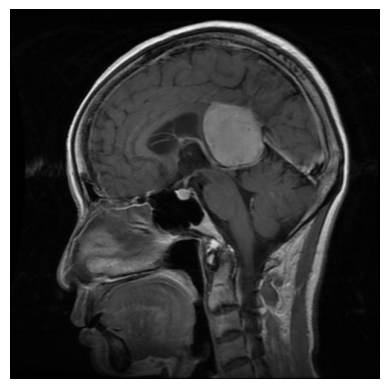

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/brainData/Tr-me_0516.jpg"  # Local path

# Open and resize the image
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))  # (width, height)

# Display
plt.imshow(raw_image)
plt.axis('off')
plt.show()


## 🧬 Step 1: Extract Image Embeddings

To ensure efficient and fast inference, we begin by computing the **image embeddings** **only once**. These embeddings represent the visual features of the MRI scan and will be reused for multiple segmentation tasks (e.g., different prompts like points or boxes), avoiding redundant computation.

Unlike the original SAM, **SAM-HQ** also generates an additional set of **intermediate embeddings**, which further boost segmentation accuracy and can also be reused across different prompt types.

By caching both the standard and intermediate embeddings, we enable high-speed, multi-prompt tumor segmentation without reprocessing the image every time.

In [ ]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


## 🎯 Use Case 1: Predict Tumor Mask from 2D Point(s)

Let’s begin with the most basic yet powerful use case of SAM-HQ: **predicting a brain tumor segmentation mask using one or more 2D points**.

SAM-HQ is a **prompt-based segmentation model**, which means it requires a prompt (such as a point or a bounding box) to guide its prediction. In this case, the prompt is a **2D point** roughly located inside the tumor region on an MRI scan.

👉 **Key insight**:
The more points you provide near the tumor boundary or interior, the better and more refined the predicted mask will be.

### 📐 Input Format

The 2D points should follow this shape:

```
[number_of_images, number_of_predictions, number_of_points_per_mask, 2]
```

This allows two flexible modes:

* Predict a **single mask** using multiple points as a combined prompt.
* Predict **one mask per point**, allowing multiple localized predictions in one go.

In this medical adaptation, think of each 2D point as a radiologist click marking a suspected tumor area. This method is especially helpful in semi-automatic diagnosis workflows.


<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


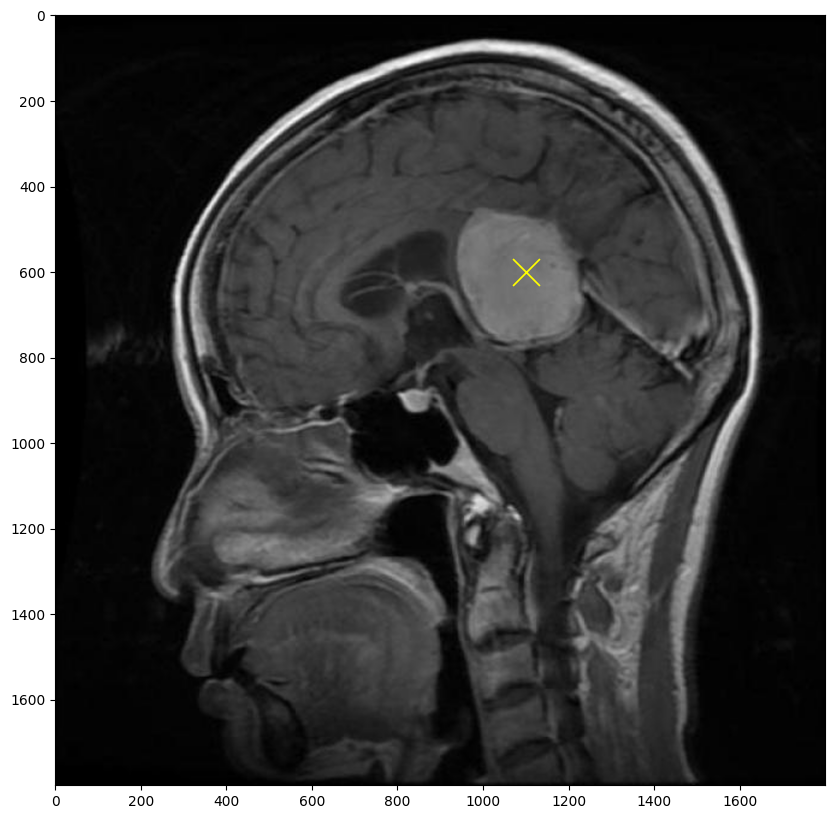

In [ ]:
input_points = [[[1100, 600]]]
show_points_on_image(raw_image, input_points[0])


### ⚙️ Efficient Tumor Mask Prediction with Pre-computed Embeddings

To perform point-based tumor segmentation efficiently, we **pass the raw MRI image and the 2D point(s)** to the SAM-HQ processor. This prepares the prompt in the correct format for the model.

Instead of recomputing embeddings each time, we reuse the **pre-computed image and intermediate embeddings**. This has two main benefits:

* ⏱ **Faster inference** – The heavy vision encoder step is skipped.
* 🔁 **Reusable workflow** – You can run multiple prompt-based predictions (e.g., different points or boxes) without reprocessing the image.

This is particularly valuable when working with high-resolution medical images like MRIs, where performance and responsiveness matter.

In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not needed
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


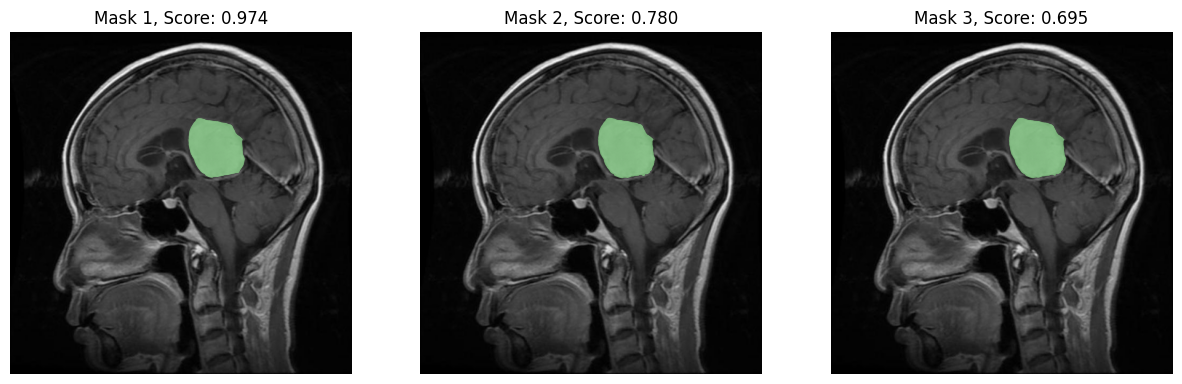

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


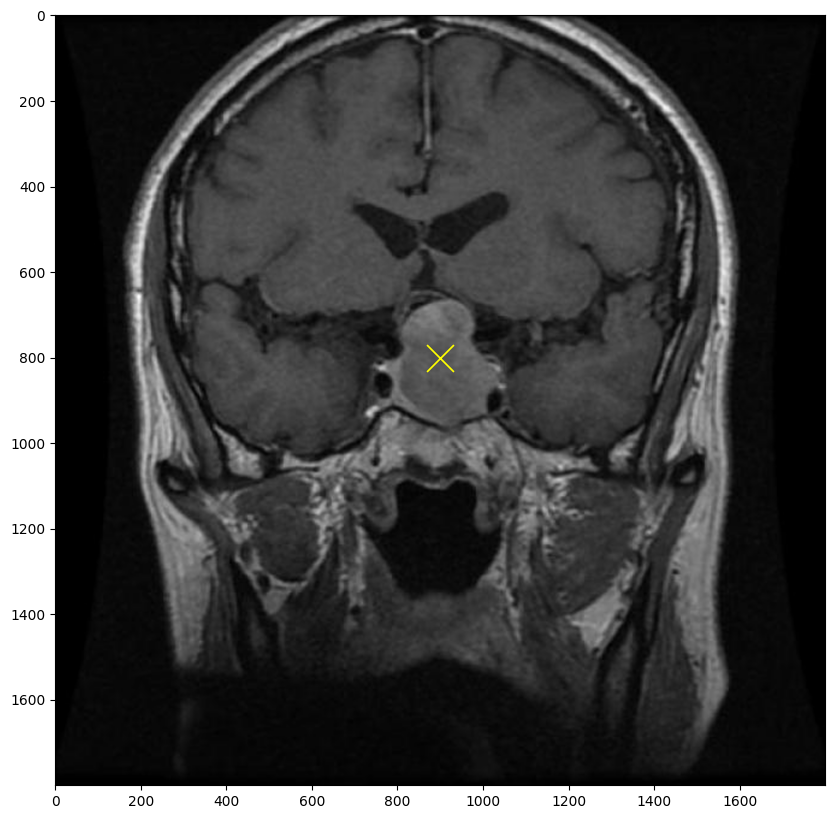

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


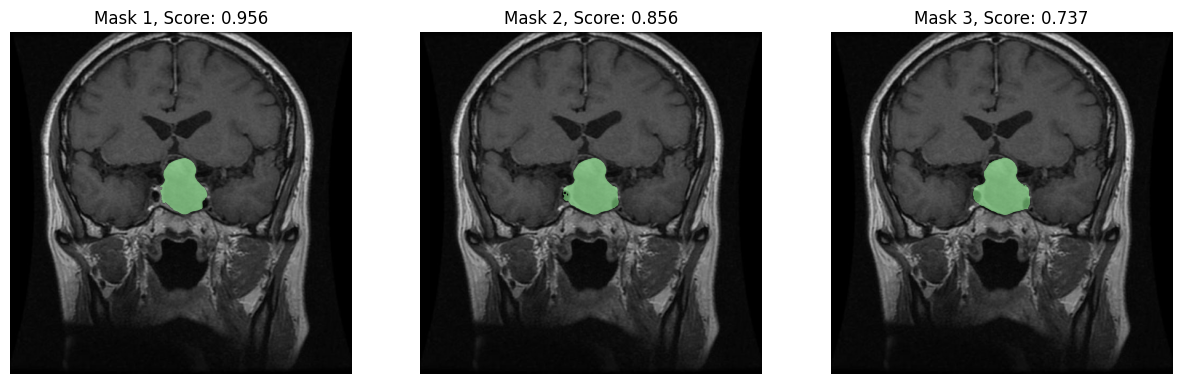

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/brainData/Pituitary Macroadenoma.jpg"  # Local path

# Open and resize the image
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))  # (width, height)

inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

input_points = [[[900, 800]]]
show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not needed
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

show_masks_on_image(raw_image, masks[0], scores)


<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


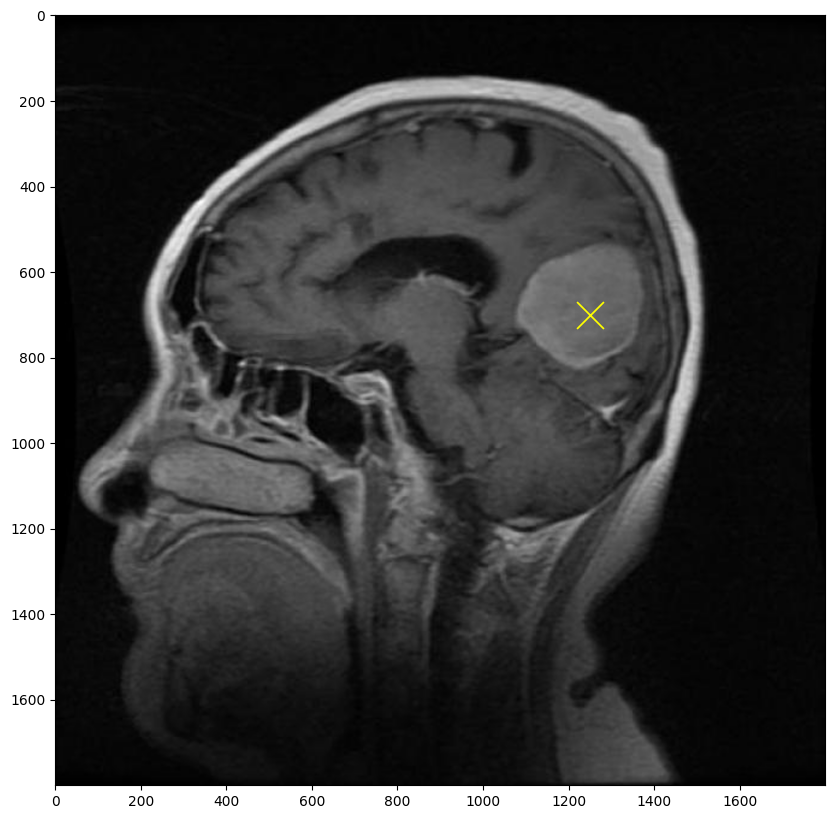

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


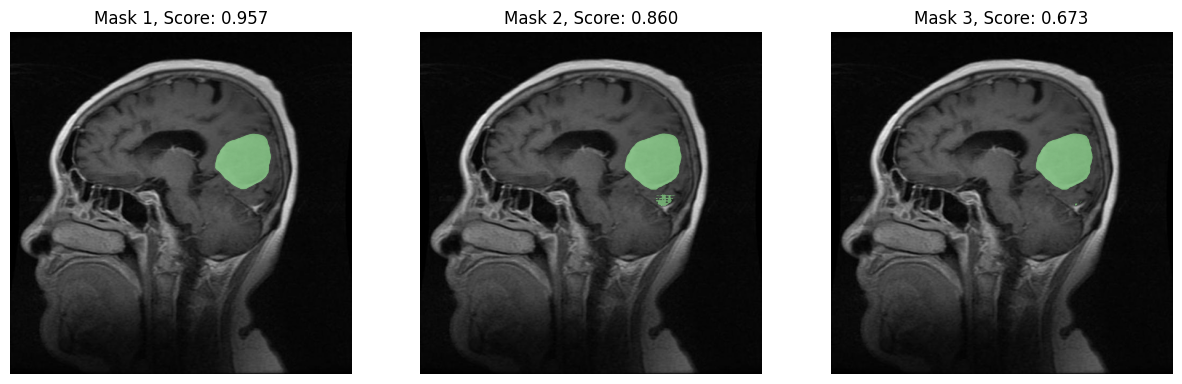

In [ ]:
img_path = "/content/brainData/Meningioma.jpg"  # Local path

# Open and resize the image
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))  # (width, height)

inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

input_points = [[[1250, 700]]]
show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not needed
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

show_masks_on_image(raw_image, masks[0], scores)



### 📊 Mask Ranking by IoU Score

After running the model, the predicted segmentation masks are **automatically sorted based on their IoU (Intersection over Union) scores**.

The **first mask** in the output typically corresponds to the **most confident prediction**—in this case, it usually aligns well with the tumor region indicated by the provided 2D point.

This IoU-based ordering is useful in medical imaging scenarios, where selecting the most accurate mask matters for diagnosis or surgical planning.

You can also feed a set of points to predict a single mask. Let's try to predict a mask, given two points:

<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


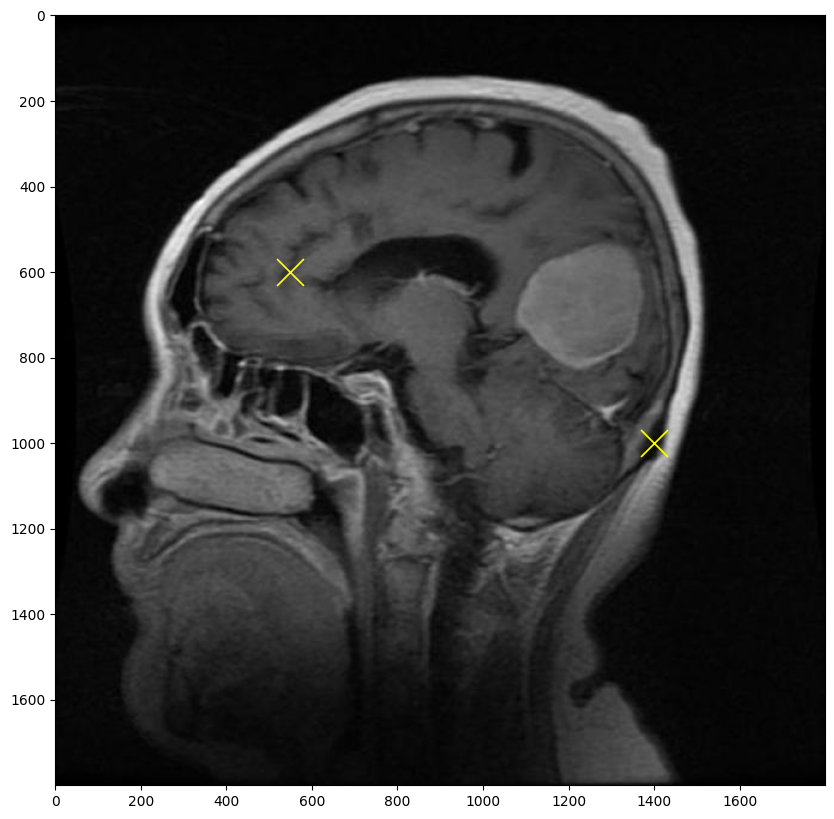

In [ ]:
input_points = [[[550, 600], [1400, 1000]]]
show_points_on_image(raw_image, input_points)

In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not needed
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


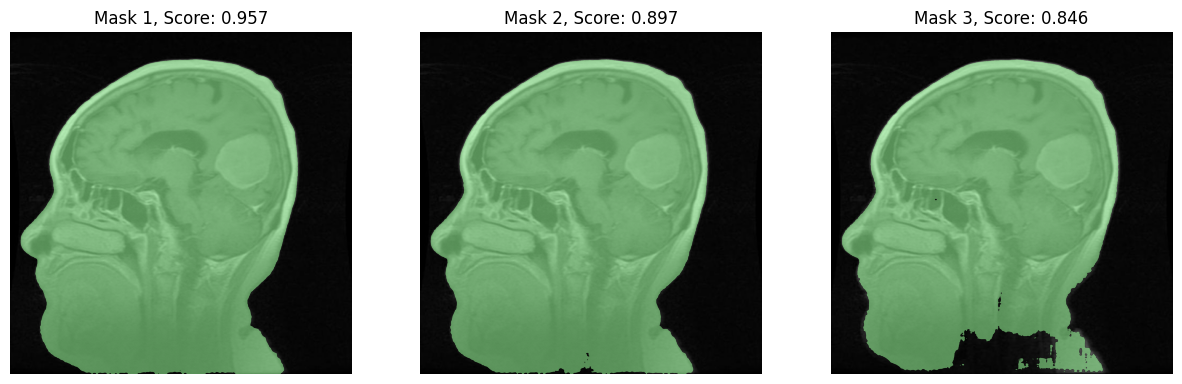

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

In this case it seems to create a segmentation mask for the entire car. Great!

## 📦 Use Case 2: Predict Tumor Masks Using Bounding Boxes

Another effective way to guide SAM-HQ is by using **bounding boxes** instead of points.

In a medical imaging context, you can manually or programmatically draw a bounding box around the **suspected tumor region**. This serves as a coarse prompt to help the model focus its segmentation within a defined area.

### 📐 Bounding Box Format

Each bounding box should be formatted as:

```
[x_min, y_min, x_max, y_max]
```

This represents the **top-left** and **bottom-right** corners of the box enclosing the tumor.

Bounding box-based prompting is ideal when:

* A radiologist quickly annotates the tumor area.
* You're automating based on ROI detection algorithms.
* You want tighter control over segmentation boundaries.


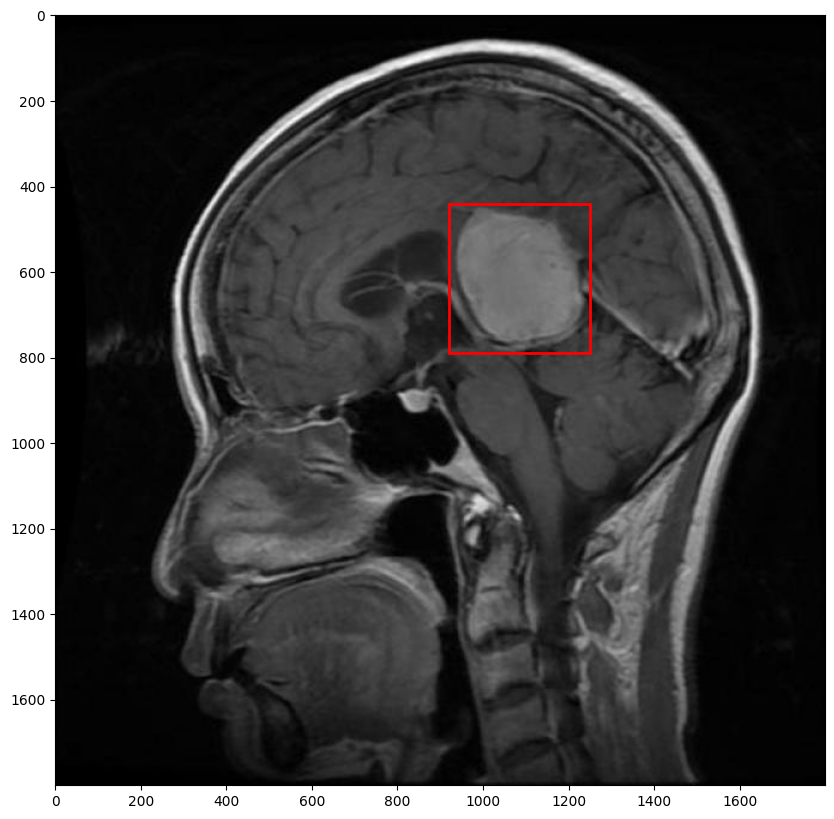

In [ ]:
img_path = "/content/brainData/Tr-me_0516.jpg"  # Local path
# Open and resize the image
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))  # (width, height)

inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

input_boxes = [[[920, 440, 1250, 790]]]
show_boxes_on_image(raw_image, input_boxes[0])

We’ll now segment the **tumor located inside a given bounding box**.

Just run the snippet below using your pre-computed embeddings and the box coordinates:

In [ ]:
inputs = processor(raw_image, input_boxes=[input_boxes], return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 1, 4])

In [ ]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


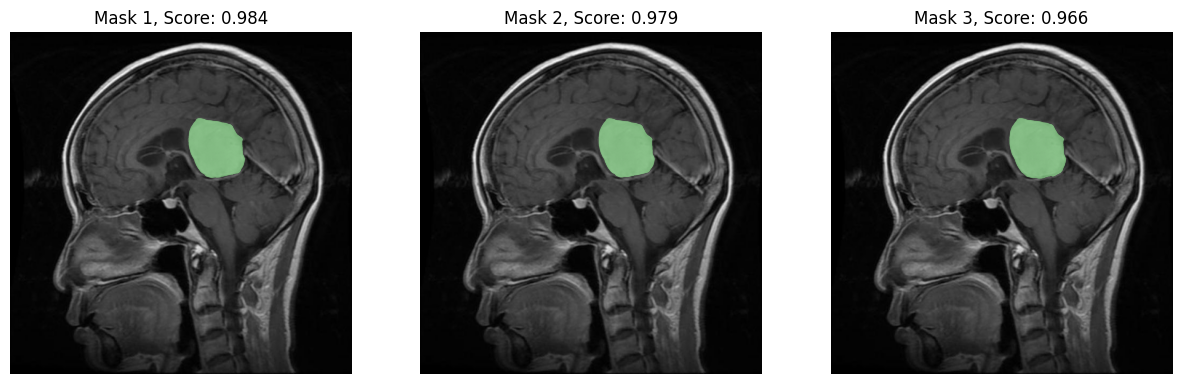

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

### 📦 Note on Multiple Bounding Boxes

You can provide **multiple bounding boxes** as input, but keep in mind:

* The model will generate **one prediction per bounding box**.
* You **cannot combine multiple boxes** into a single unified prediction.

However, you *can* combine a **bounding box with 2D points** to guide the model more precisely—especially useful in complex or irregular tumor regions. We’ll explore that in the next section.

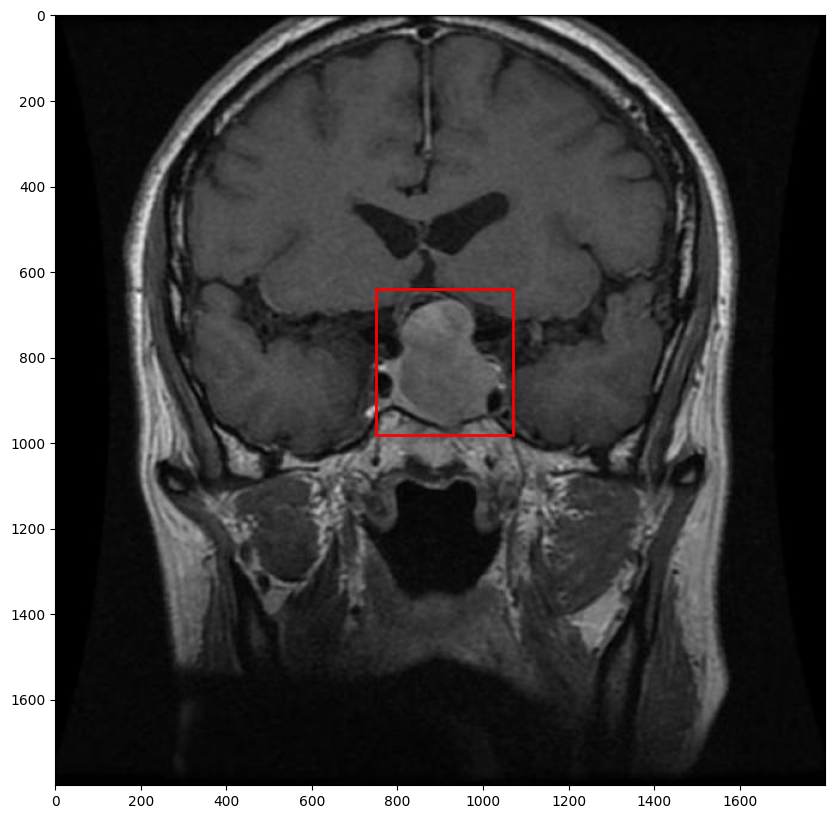

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


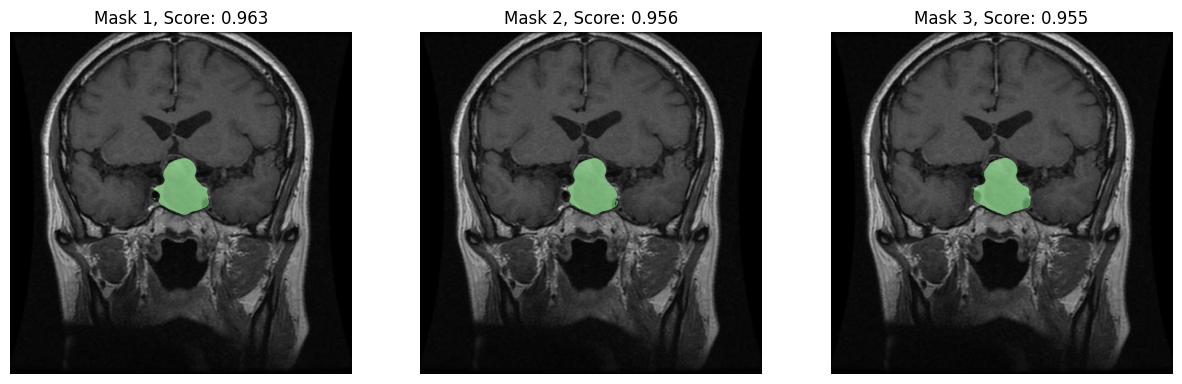

In [ ]:
img_path = "/content/brainData/Pituitary Macroadenoma.jpg"  # Local path
# Open and resize the image
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))  # (width, height)

inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

input_boxes = [[[750, 640, 1070, 980]]]
show_boxes_on_image(raw_image, input_boxes[0])

inputs = processor(raw_image, input_boxes=[input_boxes], return_tensors="pt").to(device)
inputs["input_boxes"].shape

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

show_masks_on_image(raw_image, masks[0], scores)


## 🧠 Use Case 3: Predict Tumor Masks Using Points + Bounding Box

You can combine both prompting methods—**2D points and bounding boxes**—for more precise segmentation.

By providing a bounding box to define the general tumor area and a point to refine the exact region inside, the model generates a **more accurate and focused mask**.

This is especially helpful for **irregularly shaped tumors** or when additional guidance is needed to disambiguate overlapping regions.


<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


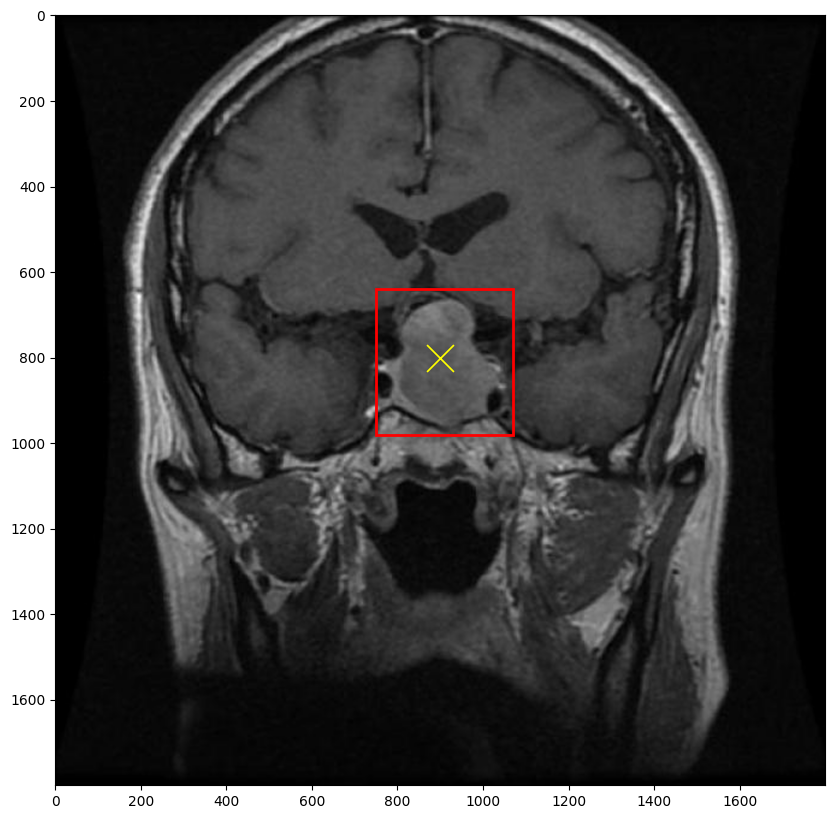

In [ ]:
input_boxes = [[[750, 640, 1070, 980]]]
input_points = [[[900, 800]]]

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0])

In [ ]:
inputs = processor(raw_image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


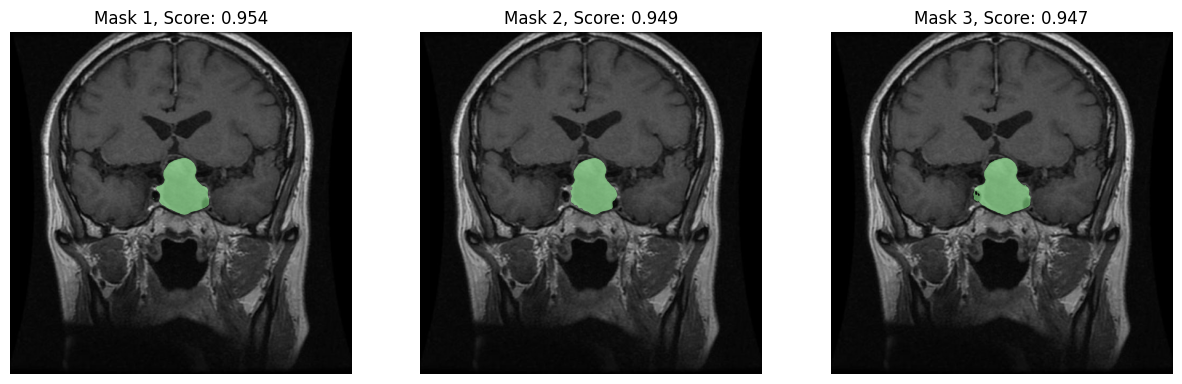

In [ ]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

## 🧪 Use Case 4: Predict Multiple Tumor Masks per MRI Image

SAM-HQ also supports generating **multiple segmentation masks** for a single MRI scan—useful when:

* Multiple tumor regions exist in one image
* You want to explore **alternative segmentation hypotheses**

This can be achieved in two ways:

* **Multiple 2D points** → One prediction per point (via `number_of_predictions` dimension)
* **Multiple bounding boxes** → One prediction per box

This is ideal for complex cases with **multi-focal tumors** or when seeking **diverse candidate masks** for medical review.

<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


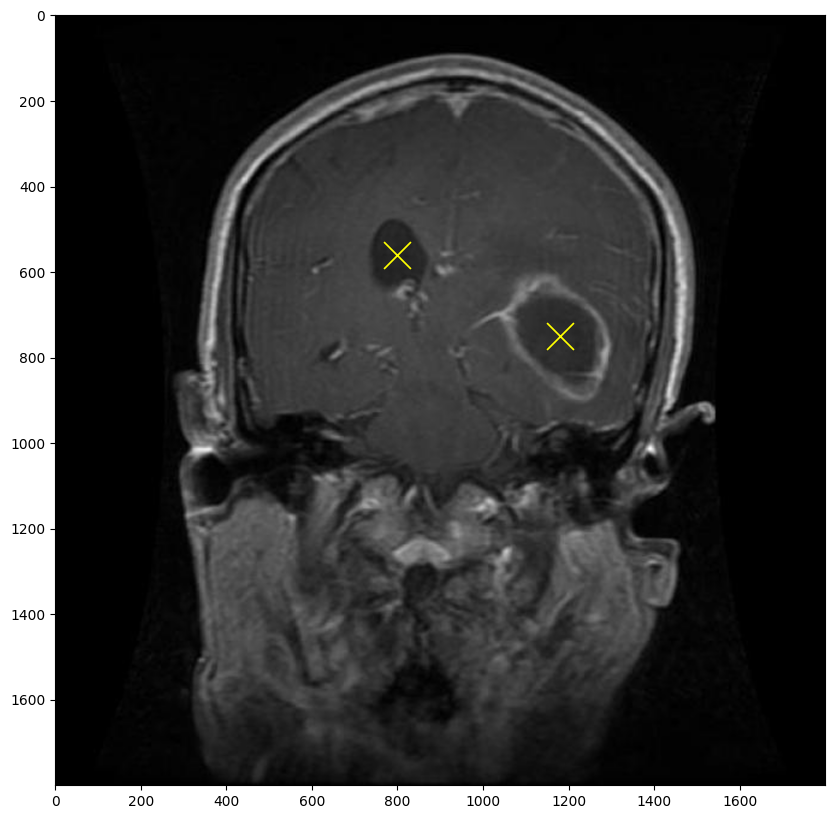

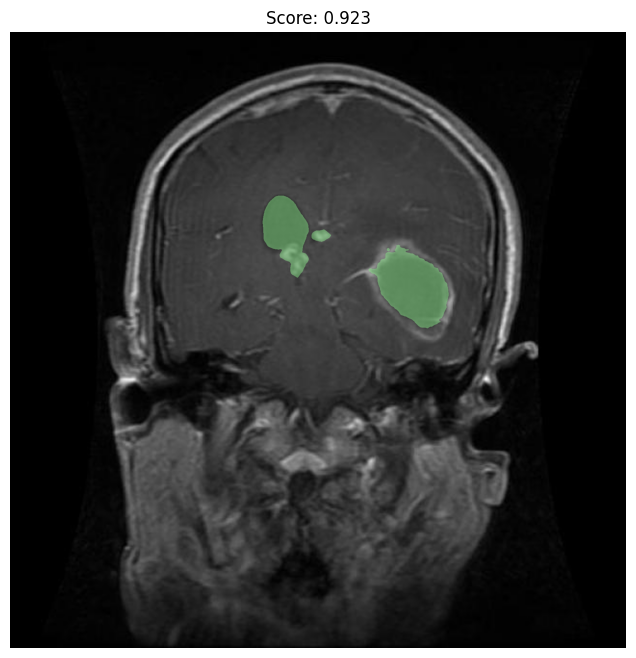

In [ ]:
# Load and preprocess the image
img_path = "/content/brainData/Glioblastoma.jpg"
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))
inputs = processor(raw_image, return_tensors="pt").to(device)

# Generate embeddings
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

# Define input points (prompt)
input_points = [[[800, 560], [1180, 750]]]
show_points_on_image(raw_image, input_points)  # Optional: just for visualization

# Prepare new inputs with prompts
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
inputs.pop("pixel_values", None)

inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

# Model inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process masks and get scores
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores.cpu().numpy()

# Extract first mask and score
mask = masks[0][0][0].numpy()
score = scores[0, 0, 0]

# Create a light green RGBA overlay for the mask
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
colored_mask[..., 0] = 0.56  # Red
colored_mask[..., 1] = 0.93  # Green
colored_mask[..., 2] = 0.56  # Blue
colored_mask[..., 3] = 0.5 * mask  # Alpha (transparency where mask==1)

# Display image with light green mask overlay
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.imshow(colored_mask)
plt.title(f"Score: {score:.3f}")
plt.axis('off')
plt.show()


<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


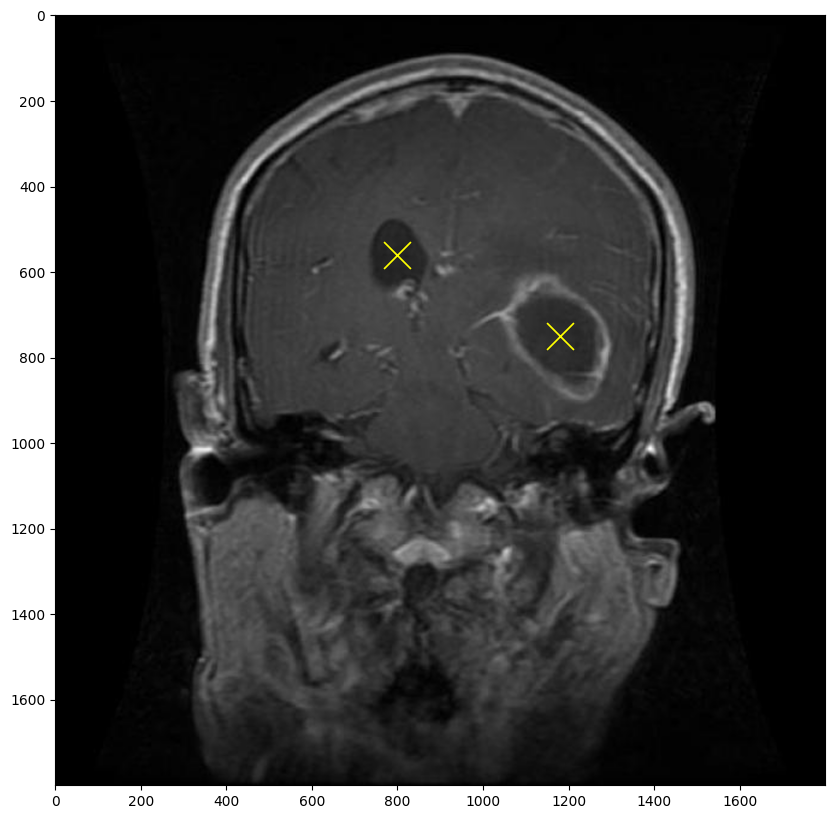

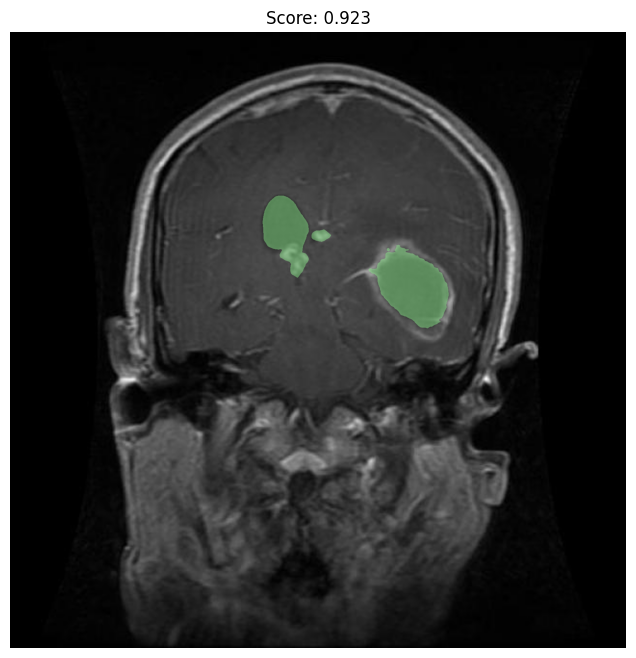

✅ Saved scanning animation as mask_scan.gif


In [ ]:
import torch
from transformers import SamProcessor, SamModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imageio  # ← new import

# Load and preprocess the image
img_path = "/content/brainData/Glioblastoma.jpg"
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))
inputs = processor(raw_image, return_tensors="pt").to(device)

# Generate embeddings
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

# Define input points (prompt)
input_points = [[[800, 560], [1180, 750]]]
show_points_on_image(raw_image, input_points)  # Optional: just for visualization

# Prepare new inputs with prompts
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

# Model inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process masks and get scores
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores.cpu().numpy()

# Extract first mask and score
mask = masks[0][0][0].numpy()      # shape: (1800, 1800)
score = scores[0, 0, 0]

# Create a light green RGBA overlay for the mask
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
colored_mask[..., 0] = 0.56  # Red
colored_mask[..., 1] = 0.93  # Green
colored_mask[..., 2] = 0.56  # Blue
colored_mask[..., 3] = 0.5 * mask  # Alpha (transparency where mask==1)

# Display image with light green mask overlay
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.imshow(colored_mask)
plt.title(f"Score: {score:.3f}")
plt.axis('off')
plt.show()

# Convert PIL image to numpy array
img_np = np.array(raw_image)       # shape (1800,1800,3), dtype=uint8
H, W = mask.shape

frames = []
step = 20  # pixels per frame (smaller→smoother)

for x in range(0, W + step, step):
    # build a partial mask only up to column x
    partial = np.zeros_like(mask)
    partial[:, :x] = mask[:, :x]

    # slice the RGBA overlay to match partial mask
    overlay = np.zeros_like(colored_mask)
    overlay[..., :3] = colored_mask[..., :3]
    overlay[..., 3] = 0.5 * partial

    # composite overlay onto the image
    o_rgb = (overlay[..., :3] * 255).astype(np.uint8)
    alpha = overlay[..., 3][..., None]  # shape (H,W,1)
    frame = (img_np * (1 - alpha) + o_rgb * alpha).astype(np.uint8)

    frames.append(frame)

# write out the GIF at 15 fps
imageio.mimsave("mask_scan.gif", frames, fps=15)
print("✅ Saved scanning animation as mask_scan.gif")


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


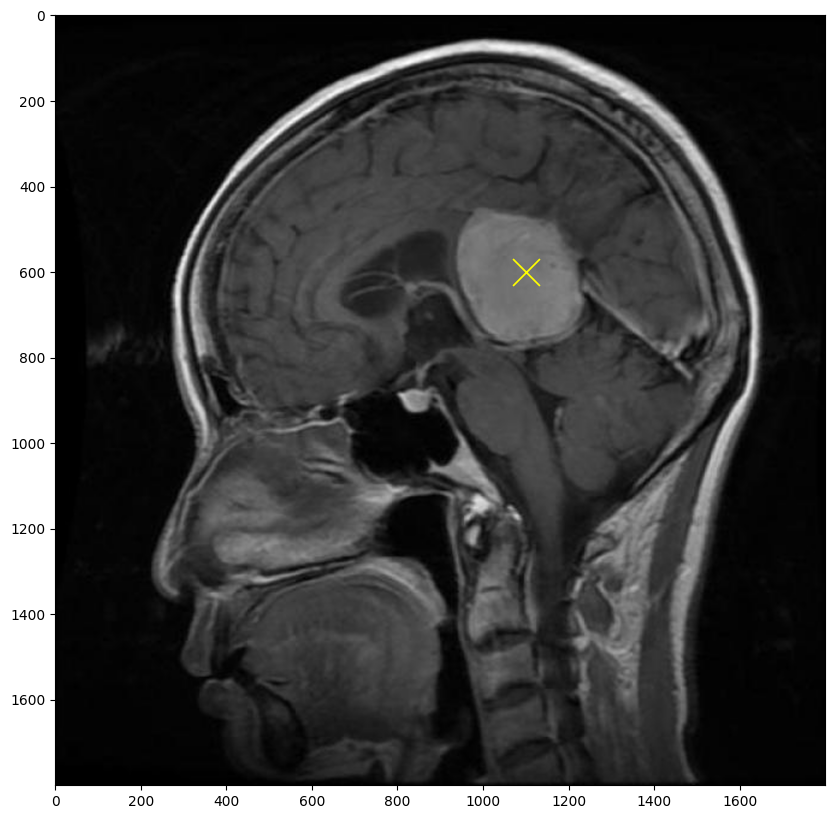

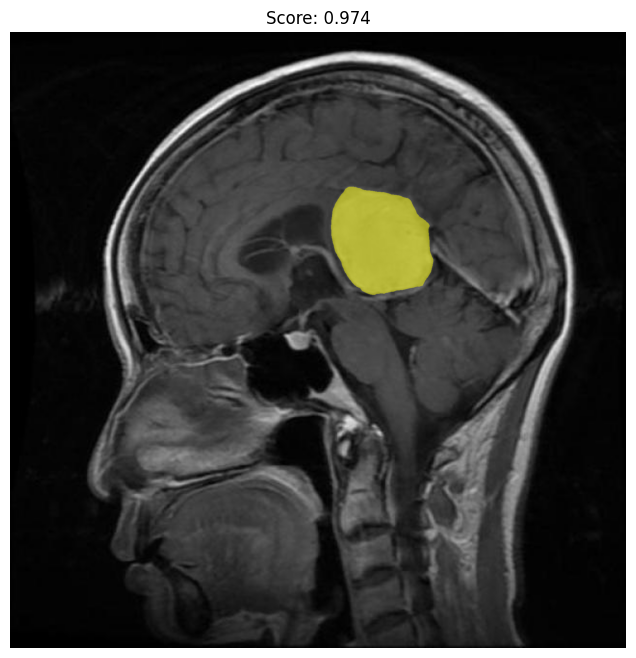

✅ Saved scanning animation as mask_scan.gif


In [ ]:
# Load and preprocess the image
img_path = "/content/brainData/Tr-me_0516.jpg"
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))
inputs = processor(raw_image, return_tensors="pt").to(device)

# Generate embeddings
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

# Define input points (prompt)
input_points = [[[1100, 600]]]
show_points_on_image(raw_image, input_points[0])  # Optional: just for visualization

# Prepare new inputs with prompts
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

# Model inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process masks and get scores
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores.cpu().numpy()

# Extract first mask and score
mask = masks[0][0][0].numpy()      # shape: (1800, 1800)
score = scores[0, 0, 0]

# Create a light green RGBA overlay for the mask
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
colored_mask[..., 0] = 1.0         # Red channel
colored_mask[..., 1] = 1.0         # Green channel
colored_mask[..., 2] = 0.0         # Blue channel
colored_mask[..., 3] = 0.5 * mask  # Alpha (transparency where mask==1)

# Display image with light green mask overlay
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.imshow(colored_mask)
plt.title(f"Score: {score:.3f}")
plt.axis('off')
plt.show()

# Convert PIL image to numpy array
img_np = np.array(raw_image)       # shape (1800,1800,3), dtype=uint8
H, W = mask.shape

frames = []
step = 20  # pixels per frame (smaller→smoother)

for x in range(0, W + step, step):
    # build a partial mask only up to column x
    partial = np.zeros_like(mask)
    partial[:, :x] = mask[:, :x]

    # slice the RGBA overlay to match partial mask
    overlay = np.zeros_like(colored_mask)
    overlay[..., :3] = colored_mask[..., :3]
    overlay[..., 3] = 0.5 * partial

    # composite overlay onto the image
    o_rgb = (overlay[..., :3] * 255).astype(np.uint8)
    alpha = overlay[..., 3][..., None]  # shape (H,W,1)
    frame = (img_np * (1 - alpha) + o_rgb * alpha).astype(np.uint8)

    frames.append(frame)

# write out the GIF at 15 fps
imageio.mimsave("V2-mask_scan.gif", frames, fps=15)
print("✅ Saved scanning animation as mask_scan.gif")


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
<ipython-input-4-2cfd21d50f17>:73: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)
<ipython-input-4-2cfd21d50f17>:74: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


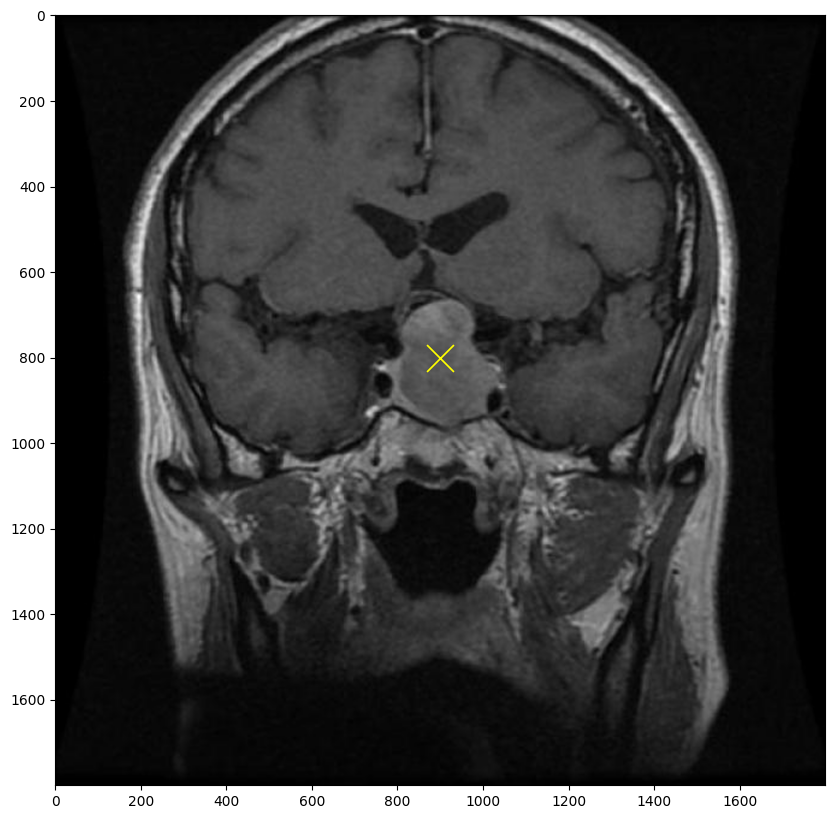

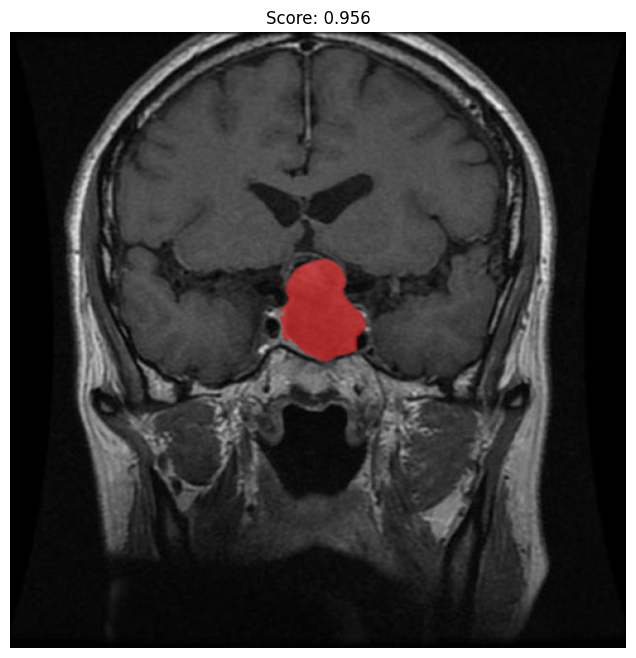

✅ Saved scanning animation as mask_scan.gif


In [ ]:
# Load and preprocess the image
img_path = "/content/brainData/Pituitary Macroadenoma.jpg"
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))
inputs = processor(raw_image, return_tensors="pt").to(device)

# Generate embeddings
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

# Define input points (prompt)
input_points = [[[900, 800]]]
show_points_on_image(raw_image, input_points[0])  # Optional: just for visualization

# Prepare new inputs with prompts
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

# Model inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process masks and get scores
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores.cpu().numpy()

# Extract first mask and score
mask = masks[0][0][0].numpy()      # shape: (1800, 1800)
score = scores[0, 0, 0]

# Create a light green RGBA overlay for the mask
# Red overlay
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
colored_mask[..., 0] = 1.0         # Red channel
colored_mask[..., 1] = 0.0         # Green channel
colored_mask[..., 2] = 0.0         # Blue channel
colored_mask[..., 3] = 0.5 * mask  # Alpha (transparency where mask==1)

# Display image with light green mask overlay
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.imshow(colored_mask)
plt.title(f"Score: {score:.3f}")
plt.axis('off')
plt.show()


# Convert PIL image to numpy array
img_np = np.array(raw_image)       # shape (1800,1800,3), dtype=uint8
H, W = mask.shape

frames = []
step = 20  # pixels per frame (smaller→smoother)

for x in range(0, W + step, step):
    # build a partial mask only up to column x
    partial = np.zeros_like(mask)
    partial[:, :x] = mask[:, :x]

    # slice the RGBA overlay to match partial mask
    overlay = np.zeros_like(colored_mask)
    overlay[..., :3] = colored_mask[..., :3]
    overlay[..., 3] = 0.5 * partial

    # composite overlay onto the image
    o_rgb = (overlay[..., :3] * 255).astype(np.uint8)
    alpha = overlay[..., 3][..., None]  # shape (H,W,1)
    frame = (img_np * (1 - alpha) + o_rgb * alpha).astype(np.uint8)

    frames.append(frame)

# write out the GIF at 15 fps
imageio.mimsave("V3-mask_scan.gif", frames, fps=15)
print("✅ Saved scanning animation as mask_scan.gif")


## 📦 Feed Multiple Bounding Boxes to One MRI Image

You can also provide **multiple bounding boxes** for a single MRI image. The model will return **one tumor mask per bounding box**, allowing you to detect and segment **multiple suspected regions** within the same scan.

This is particularly useful for identifying **multi-focal tumors** or **scattered lesion areas**.


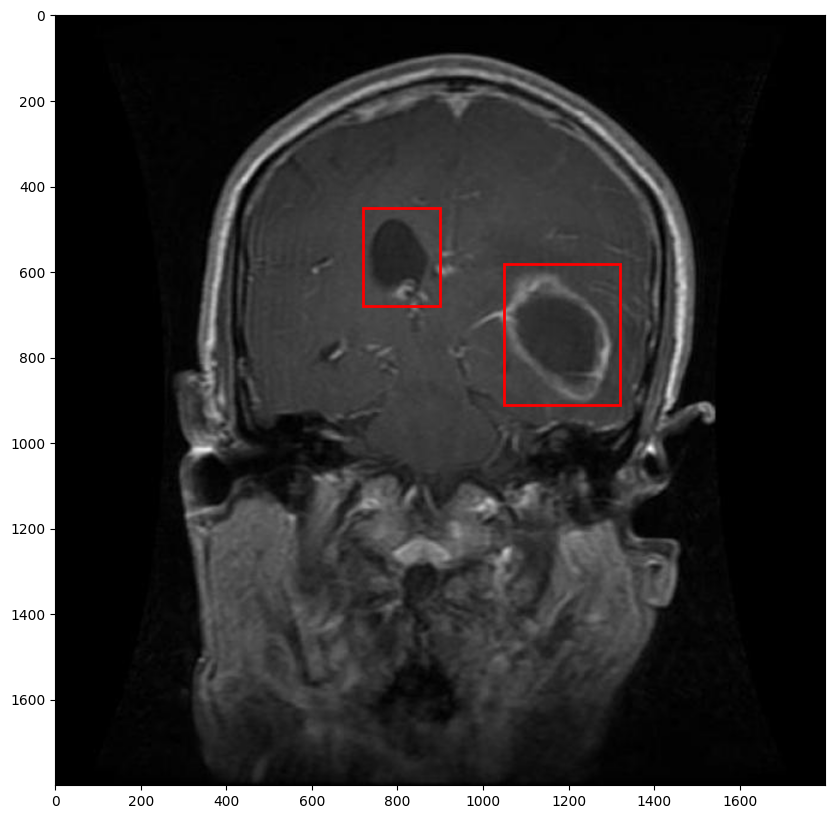

In [ ]:
# Load and preprocess the image
img_path = "/content/brainData/Glioblastoma.jpg"
raw_image = Image.open(img_path).convert("RGB").resize((1800, 1800))
inputs = processor(raw_image, return_tensors="pt").to(device)
input_boxes = [[[720, 450, 900, 680], [1050, 580, 1320, 910]]]
show_boxes_on_image(raw_image, input_boxes[0])

# Generate embeddings
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])

To match the processor’s expected format, simply structure your multiple bounding boxes correctly. Each box will be treated independently, and the model will generate a separate tumor mask for each.

In [ ]:
input_boxes = [[[720, 450, 900, 680], [1050, 580, 1320, 910]]]
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 2, 4])

To output a single tumor mask per bounding box, simply disable multi-mask prediction by setting multimask_output=False during the forward pass.

In [ ]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
scores.shape

torch.Size([1, 2, 1])


### 🧾 View Predicted Tumor Masks

As shown, we’ve predicted **2 tumor masks**—one for each bounding box provided.

Let’s now **inspect the results** to evaluate the segmentation quality and confirm tumor localization.


<ipython-input-4-2cfd21d50f17>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


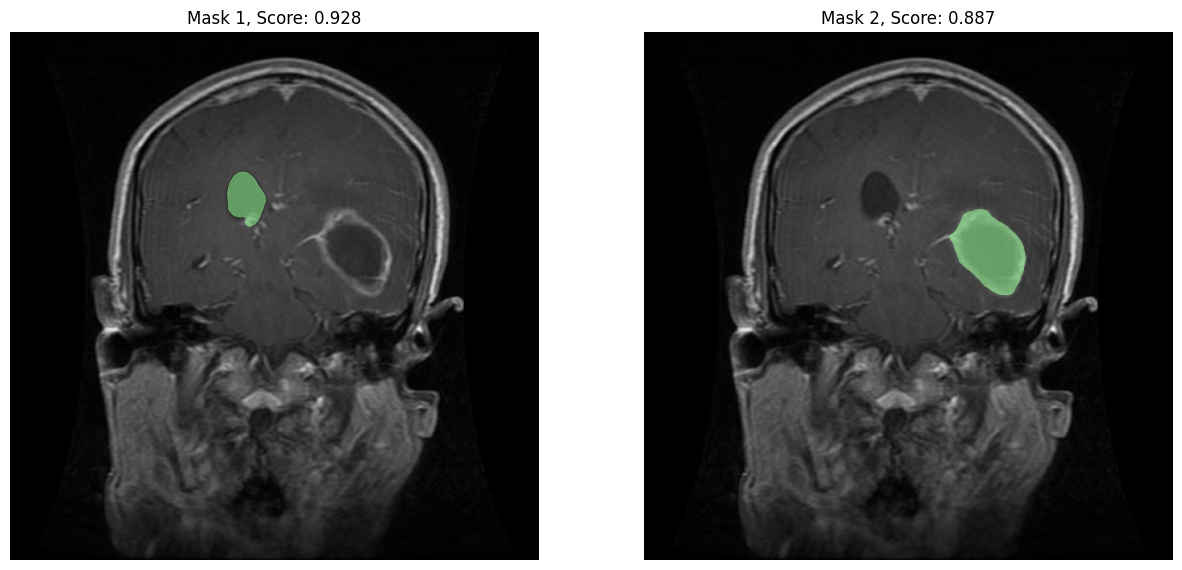

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)